# Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

# Target Value Distribution

In [4]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1
            
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')
    


PATH = './Dataset'

image_counter(PATH)

A search has been initiated within the folder named 'Dataset'.
There are 896 images in the Mild_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 2240 images in the Very_Mild_Demented folder.
The search has been completed.


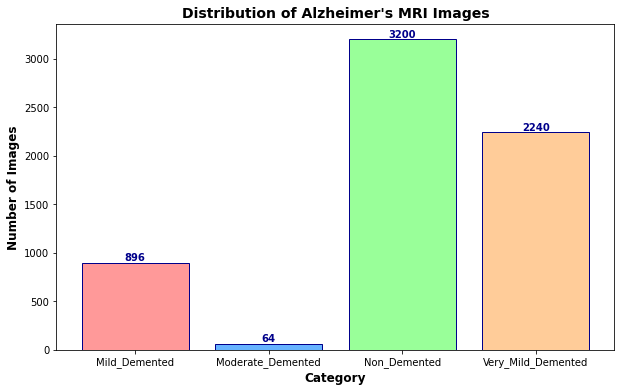

In [2]:
import matplotlib.pyplot as plt

def plot_image_distribution_bar_chart(class_dist):
    # Extract keys (labels) and values (counts) from the class_dist dictionary
    labels = list(class_dist.keys())
    values = list(class_dist.values())
    
    # Define colors for the bars
    colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']
    
    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=colors, edgecolor='darkblue')
    
    # Add labels to the bars for better clarity
    for index, value in enumerate(values):
        plt.text(index, value, str(value), ha='center', va='bottom', fontweight='bold', color='darkblue')
    
    # Add titles and labels
    plt.title("Distribution of Alzheimer's MRI Images", size=14, fontweight='bold')
    plt.xlabel('Category', size=12, fontweight='bold')
    plt.ylabel('Number of Images', size=12, fontweight='bold')
    
    # Display the plot
    plt.show()

# Given class distribution from the provided counts
class_dist = {
    'Mild_Demented': 896,
    'Moderate_Demented': 64,
    'Non_Demented': 3200,
    'Very_Mild_Demented': 2240
}

# Plot the bar chart for the distribution
plot_image_distribution_bar_chart(class_dist)


In [3]:
data = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


Pixel normalization improves the performance of a neural network. Therefore, we will go with pixel values from 0 to 1, rather than values in the range 0 to 255.

In [4]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

Min and max pixel values in the batch -> 0.0 & 1.0


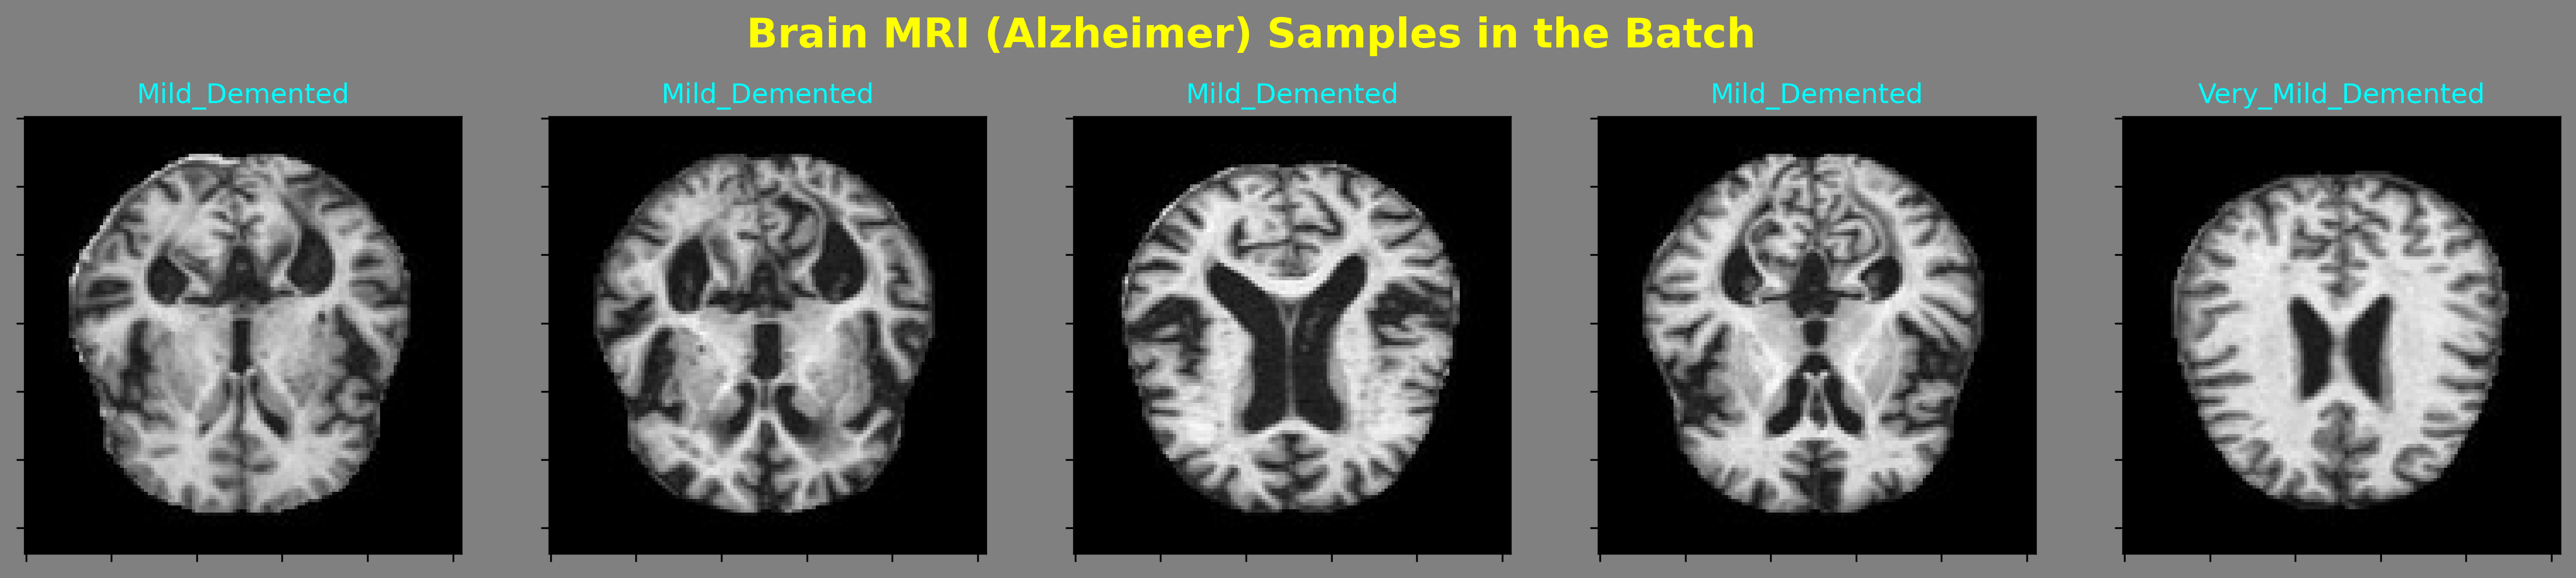

In [6]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [7]:
# Train test split
train_data, val_data, test_data = process.train_test_val_split(train_size=0.7, val_size=0.15, test_size=0.15)

In [8]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building

In [9]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    model.summary()
    
    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [10]:
def checkpoint_callback():
    
    checkpoint_filepath = '/tmp/checkpoint'
    
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 8
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [11]:
import os

# Create directory if it does not exist
if not os.path.exists('model_checkpoints'):
    os.makedirs('model_checkpoints')


In [12]:
import os
import tensorflow as tf

# Train model
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data,
                    class_weight=class_weights)


Epoch 1/8
140/140 [==============================] - 44s 297ms/step - loss: 1.4794 - accuracy: 0.3449 - val_loss: 1.2567 - val_accuracy: 0.4031
Epoch 2/8
140/140 [==============================] - 47s 330ms/step - loss: 1.1423 - accuracy: 0.5027 - val_loss: 1.3076 - val_accuracy: 0.4417
Epoch 3/8
140/140 [==============================] - 63s 450ms/step - loss: 0.7556 - accuracy: 0.6417 - val_loss: 0.9523 - val_accuracy: 0.6000
Epoch 4/8
140/140 [==============================] - 123s 881ms/step - loss: 0.3840 - accuracy: 0.7833 - val_loss: 0.4616 - val_accuracy: 0.8240
Epoch 5/8
140/140 [==============================] - 48s 342ms/step - loss: 0.1893 - accuracy: 0.9011 - val_loss: 0.2093 - val_accuracy: 0.9333
Epoch 6/8
140/140 [==============================] - 57s 403ms/step - loss: 0.0789 - accuracy: 0.9641 - val_loss: 0.1248 - val_accuracy: 0.9604
Epoch 7/8
140/140 [==============================] - 54s 385ms/step - loss: 0.0298 - accuracy: 0.9884 - val_loss: 0.3109 - val_accuracy

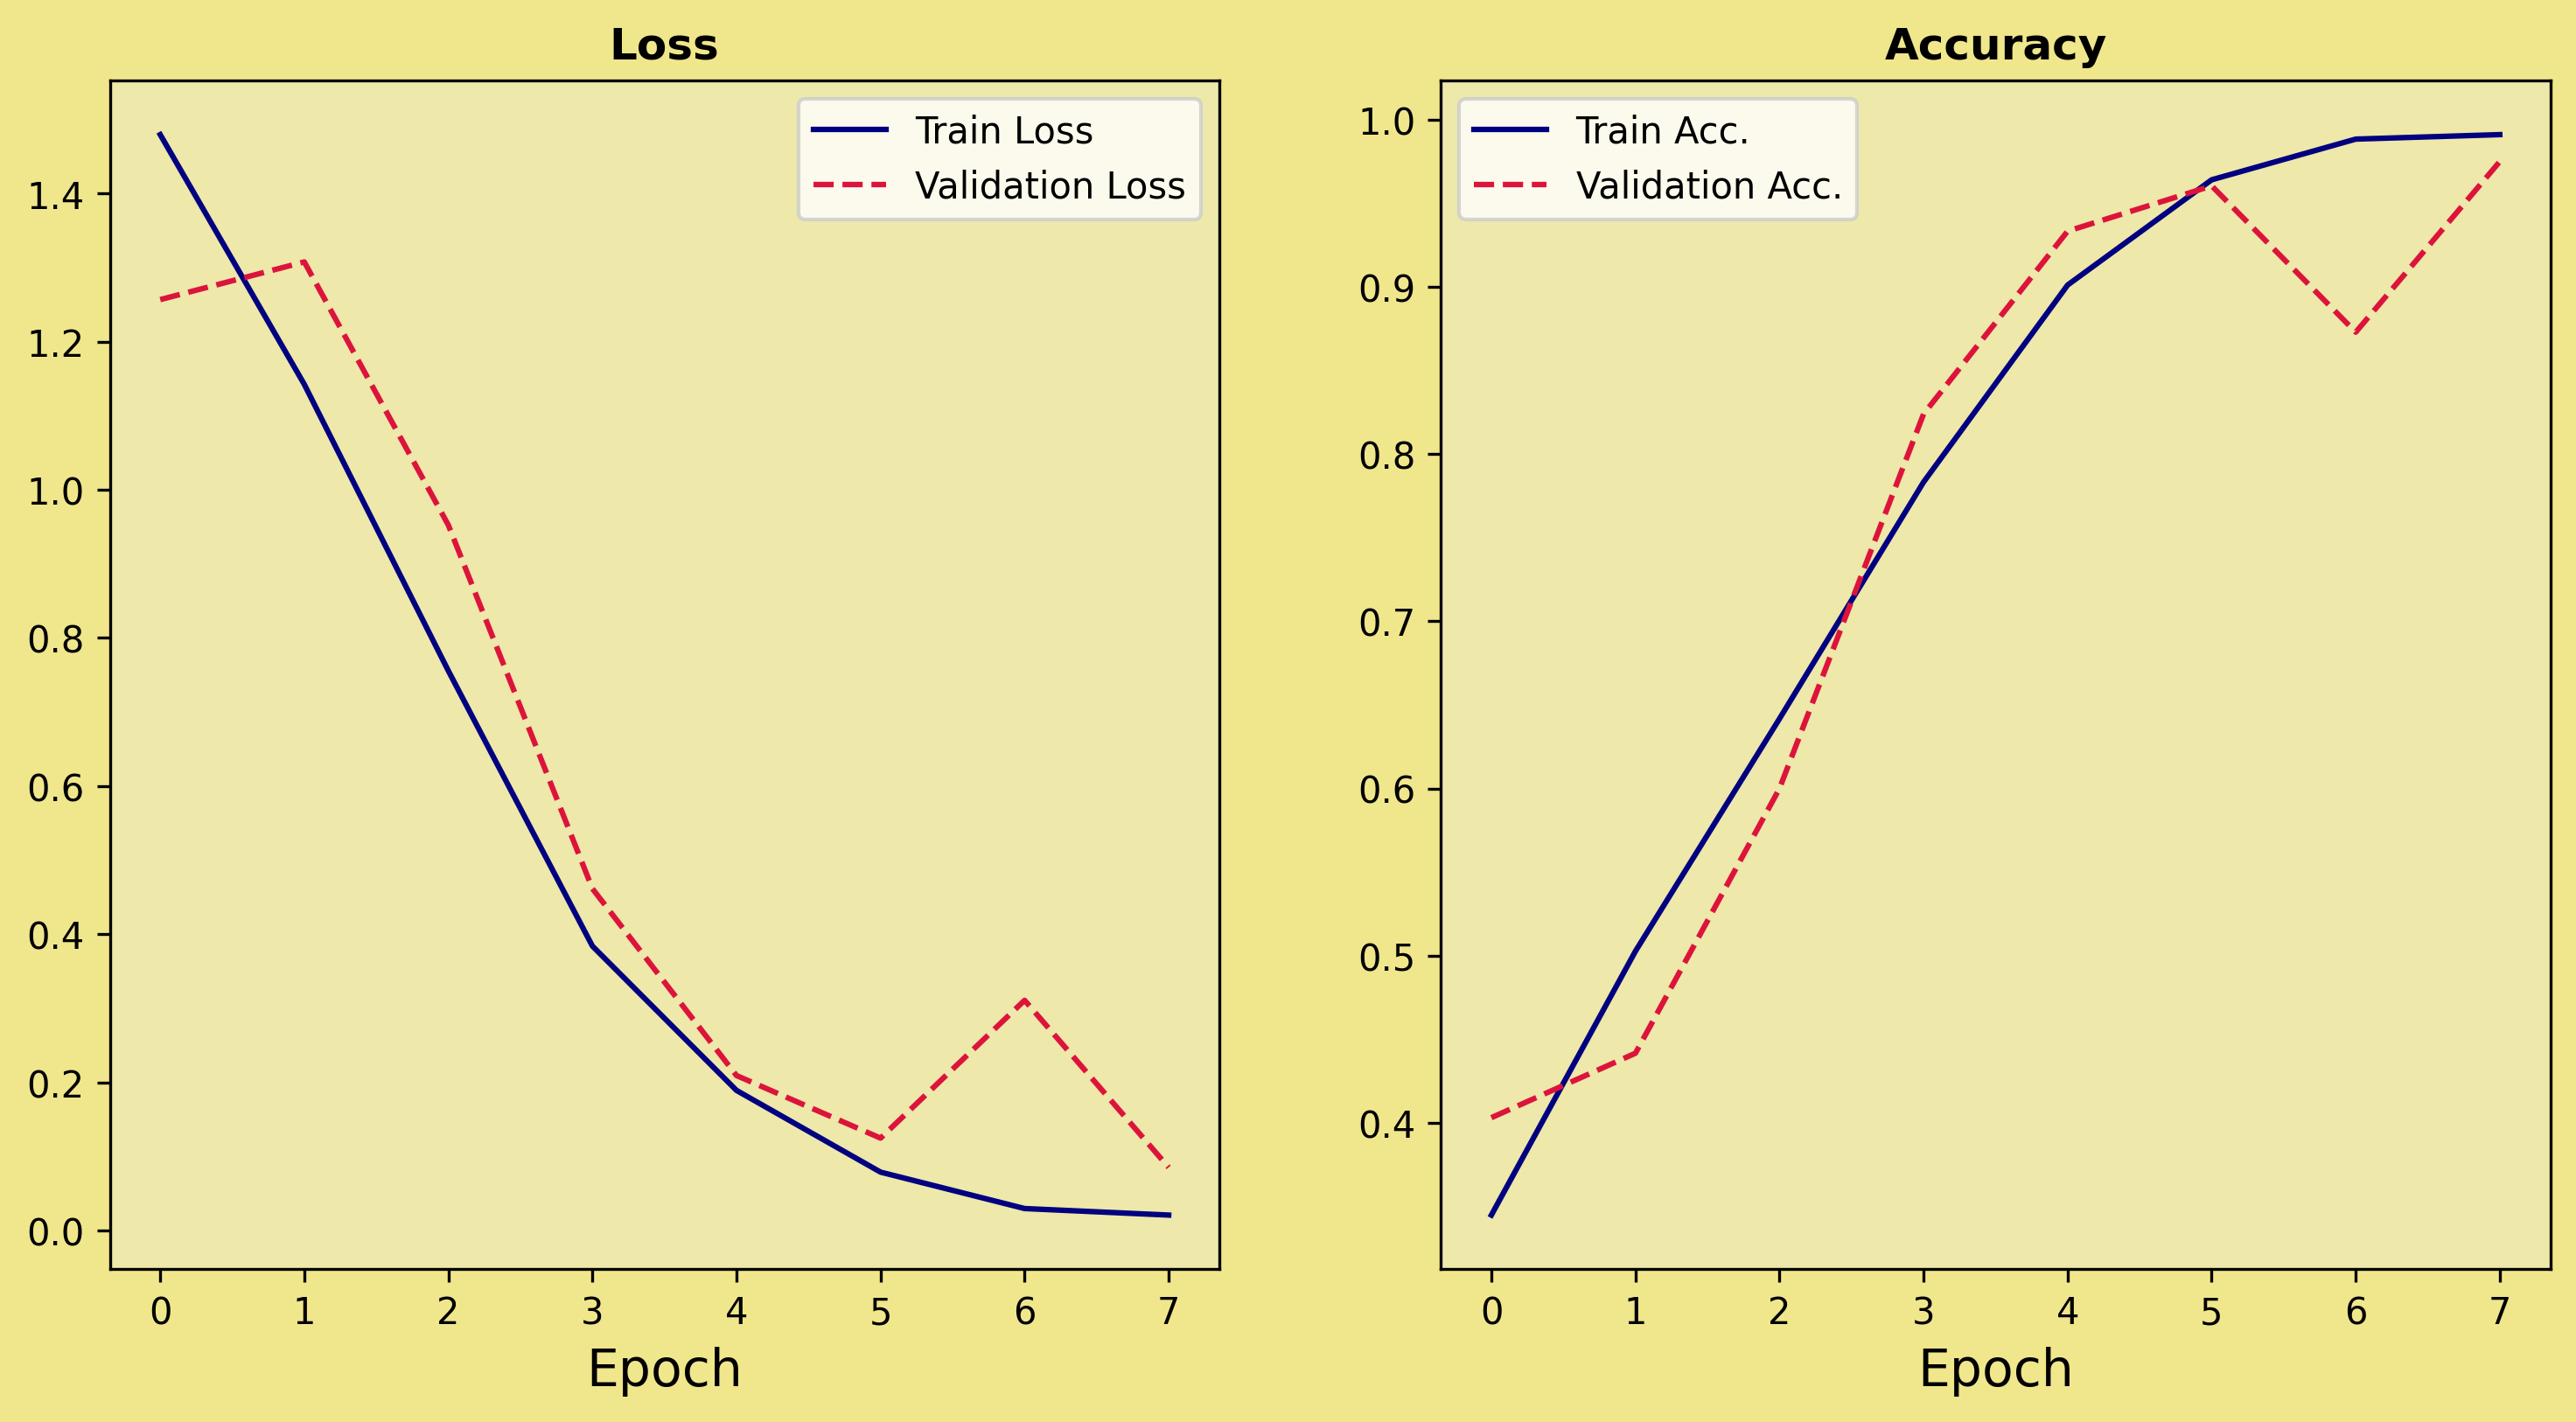

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="khaki")
ax[0].set_facecolor('palegoldenrod')  
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="navy")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="crimson", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('palegoldenrod')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="navy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="crimson", linestyle="dashed")
ax[1].legend()

In [14]:
model.evaluate(test_data)

30/30 [==============================] - 5s 102ms/step - loss: 0.1088 - accuracy: 0.9594


[0.10875499248504639, 0.9593750238418579]

In [3]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    
        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

NameError: name 'test_data' is not defined

<Figure size 1440x1440 with 0 Axes>

In [15]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)
    
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.98      0.96      0.97       123
 Moderate_Demented       1.00      1.00      1.00         7
      Non_Demented       0.97      0.96      0.96       483
Very_Mild_Demented       0.95      0.97      0.96       347

          accuracy                           0.96       960
         macro avg       0.97      0.97      0.97       960
      weighted avg       0.96      0.96      0.96       960



Text(286.1666666666666, 0.5, 'True')

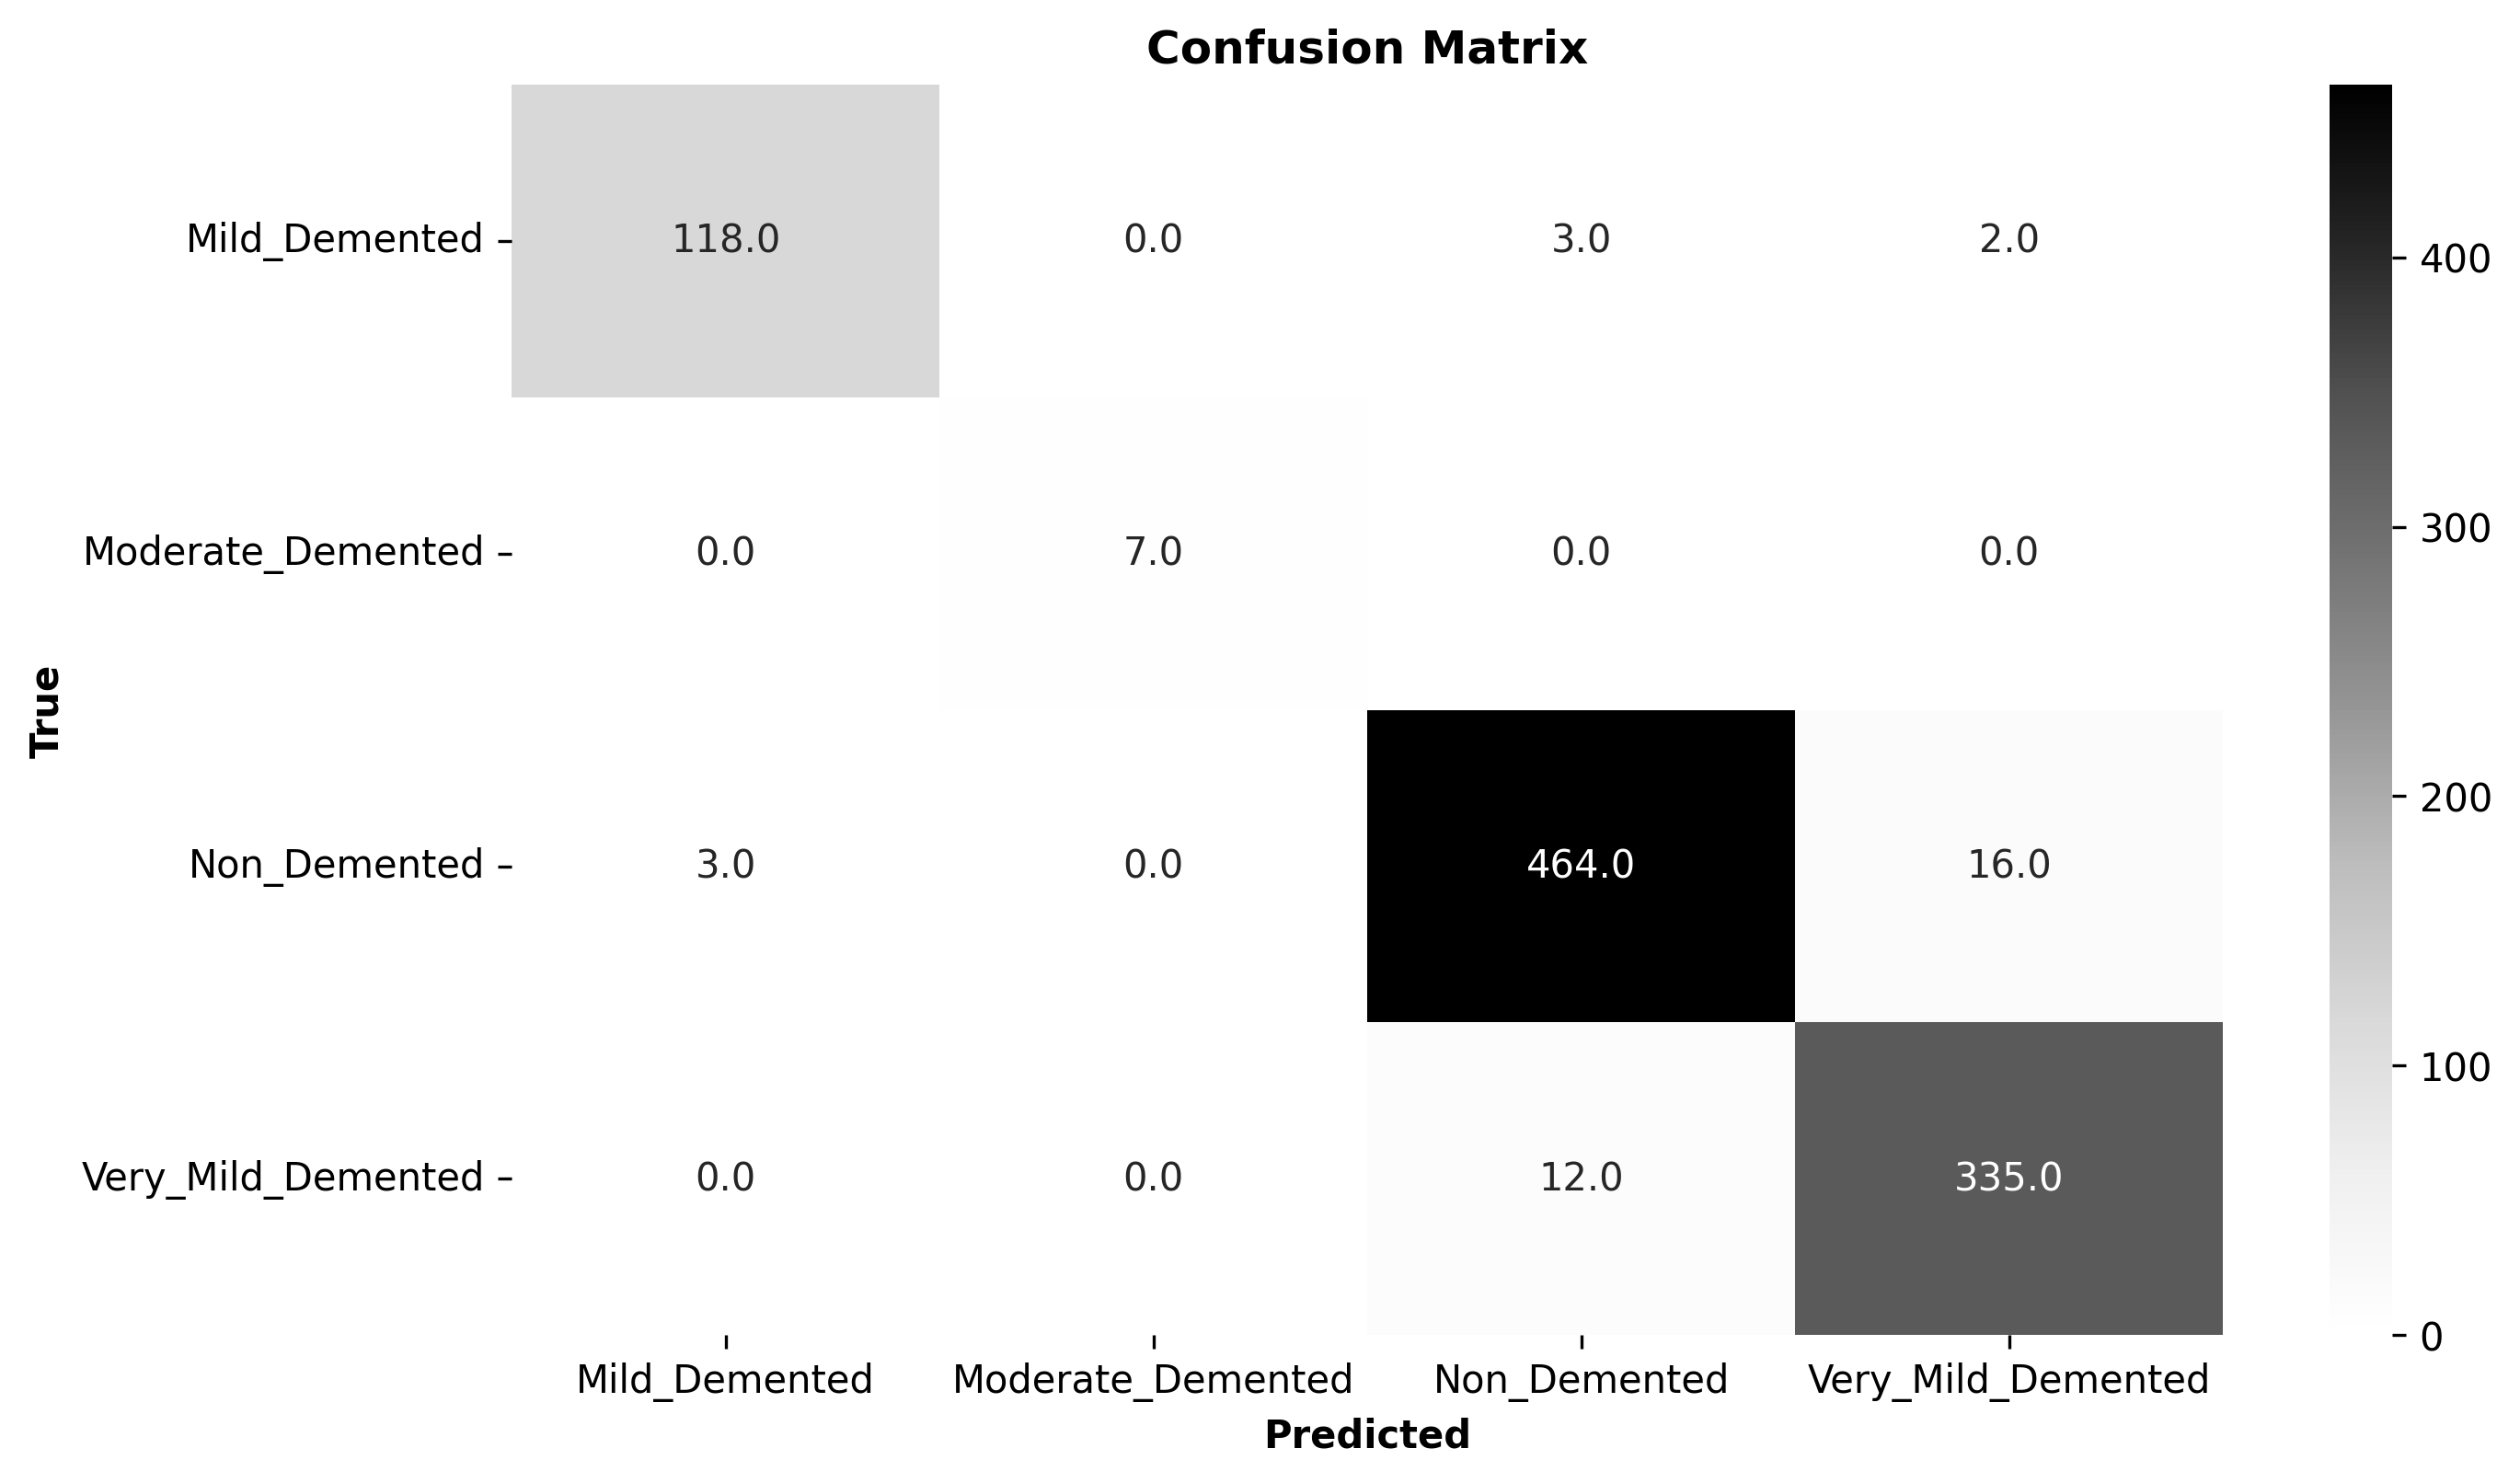

In [16]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

In [17]:
from keras.models import Sequential
from keras.layers import Dense

model.save('model.h5')
